# **Product Title-Based Category and Description Generation**

Bu notebook, ürün başlıklarından açıklama üretimi, kategori tahmini, kümeleme ve özetleme işlemlerini içeren yapay zeka destekli bir GenAI projesidir.

Proje kapsamında:
- T5 modeli ile açıklama üretimi,
- TF-IDF + Logistic Regression ile kategori sınıflandırması,
- TF-IDF + KMeans ile segmentasyon (kümelendirme),
- T5 ile uzun açıklamaların özetlenmesi,
- Sentence-Transformers ile gelişmiş embedding ve alternatif kümeleme

adımları gerçekleştirilmiştir.


## 🛠️ 1. Gerekli Kütüphanelerin Yüklenmesi

Proje boyunca kullanılacak tüm temel kütüphaneler bu aşamada içe aktarılır.  
Bunlar arasında veri işleme, makine öğrenimi, görselleştirme ve Transformers (HuggingFace) modelleri yer alır.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from transformers import pipeline, T5Tokenizer, T5ForConditionalGeneration
import torch
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

## 📥 2. Veri Seti Yükleme
Bu projede kullanılan veri seti, farklı ürün başlıklarının ve açıklamalarının dengeli olacak şekilde manuel ve yarı-otomatik yöntemlerle tarafımdan oluşturulmuştur.
Her kategoriye ait 100’er örnek içerecek biçimde tasarlanmıştır.
Bu sayede sınıflandırma ve kümeleme algoritmaları üzerinde anlamlı sonuçlar gözlemlenebilmiştir.

In [ ]:
df = pd.read_csv('/content/products_raw_1000.csv')
df.head()

,product_title,product_description,category
0,Wireless Bluetooth Earbuds,High-quality wireless earbuds with Bluetooth 5.0 and long battery life.,Electronics
1,Stainless Steel Water Bottle,Insulated water bottle keeps drinks cold for 24 hours and hot for 12 hours.,Home & Kitchen
2,Yoga Mat with Carrying Strap,Durable yoga mat with non-slip surface and convenient carrying strap.,Sports & Outdoors
3,Apple iPhone 13,Latest model of Apple iPhone with A15 Bionic chip and improved battery.,Mobile Phones
4,LED Desk Lamp,LED desk lamp with adjustable brightness and USB charging port.,Home Office


## 🔍 3. Keşifsel Veri Analizi (EDA)
Veri kümesinin yapısı, eksik değerler ve kategori dağılımı incelenir.


In [ ]:
print("Veri kümesi boyutu:", df.shape)
print("\nSütunlar:", df.columns.tolist())
print("\nEksik değerler:\n", df.isnull().sum())

Veri kümesi boyutu: (1000, 3)

Sütunlar: ['product_title', 'product_description', 'category']

Eksik değerler:
 product_title          0
product_description    0
category               0
dtype: int64


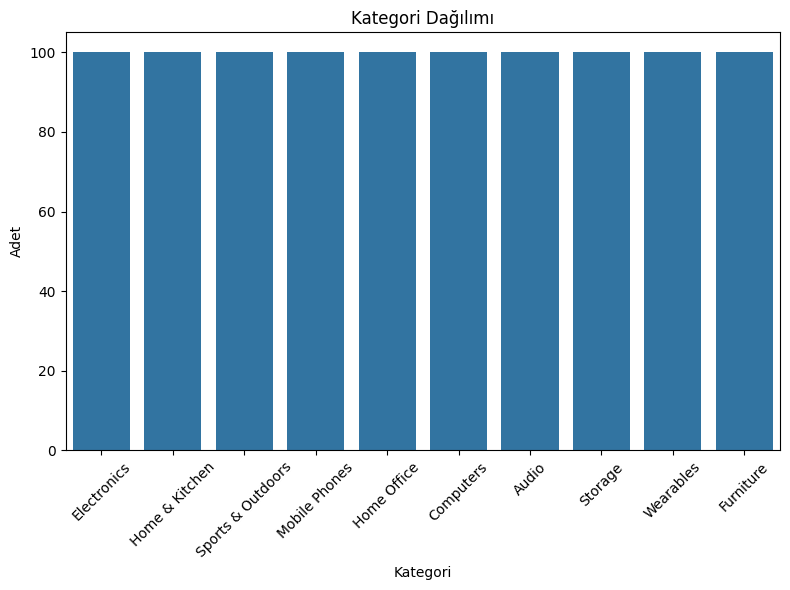

In [ ]:
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='category', order=df['category'].value_counts().index)
plt.xticks(rotation=45)
plt.title('Kategori Dağılımı')
plt.xlabel("Kategori")
plt.ylabel("Adet")
plt.tight_layout()
plt.show()

## 📝 4. Açıklama Üretimi (T5 modeli)

Ürün başlıklarından doğal dilde kısa açıklamalar üretmek için `google/flan-t5-small` modeli kullanılmıştır.  
Model, başlığı bir açıklama istemi (prompt) olarak alır ve açıklamayı serbest dilde üretir. Aşağıdaki kod, ürün başlıklarından açıklama üretmek için kullanılan `google/flan-t5-small` modelini içermektedir.

Açıklamalar bu kod ile üretilmiş ve `products_with_predictions.csv` dosyasına kaydedilmiştir.

In [ ]:
from transformers import pipeline
from tqdm import tqdm

generator = pipeline("text2text-generation", model="google/flan-t5-small")

new_descriptions = []

for title in tqdm(df['product_title'], desc="Açıklamalar üretiliyor"):
    prompt = f"Generate a short product description for: {title}"
    result = generator(prompt, max_new_tokens=60, do_sample=True)
    new_descriptions.append(result[0]['generated_text'])

df['generated_description'] = new_descriptions

df.to_csv('/content/sample_products_with_generated_desc.csv', index=False)

## 🧠 5. Kategori Tahmini – Veri Hazırlığı ve Model Eğitimi

Bu bölümde:
- `generated_description` sütunu girdi olarak,
- `category` sütunu hedef olarak belirlenmiştir.

Veri, %80 eğitim ve %20 test olacak şekilde ayrılmıştır.  
Açıklamalar TF-IDF ile vektörleştirilmiş, ardından Logistic Regression sınıflandırıcısı eğitilmiştir.

In [ ]:
X = df['generated_description']
y = df['category']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(ngram_range=(1,2), max_features=1000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

from sklearn.linear_model import LogisticRegression
model = LogisticRegression(max_iter=1000)
model.fit(X_train_tfidf, y_train)

y_pred = model.predict(X_test_tfidf)

## 📊 Kategori Sınıflandırma Sonuçları

Logistic Regression modeliyle yapılan sınıflandırma sonuçları bu adımda değerlendirilmiştir.  
Doğruluk, precision, recall ve F1-score gibi metrikler hesaplanarak modelin başarımı analiz edilmiştir.


In [ ]:
from sklearn.metrics import accuracy_score, classification_report

y_pred = model.predict(X_test_tfidf)

print("🔍 Doğruluk (Accuracy):", accuracy_score(y_test, y_pred))
print("\n📊 Classification Report:\n\n", classification_report(y_test, y_pred))


🔍 Doğruluk (Accuracy): 1.0

📊 Classification Report:

                    precision    recall  f1-score   support

            Audio       1.00      1.00      1.00        20
        Computers       1.00      1.00      1.00        16
      Electronics       1.00      1.00      1.00        20
        Furniture       1.00      1.00      1.00        30
   Home & Kitchen       1.00      1.00      1.00        19
      Home Office       1.00      1.00      1.00        20
    Mobile Phones       1.00      1.00      1.00        16
Sports & Outdoors       1.00      1.00      1.00        17
          Storage       1.00      1.00      1.00        22
        Wearables       1.00      1.00      1.00        20

         accuracy                           1.00       200
        macro avg       1.00      1.00      1.00       200
     weighted avg       1.00      1.00      1.00       200



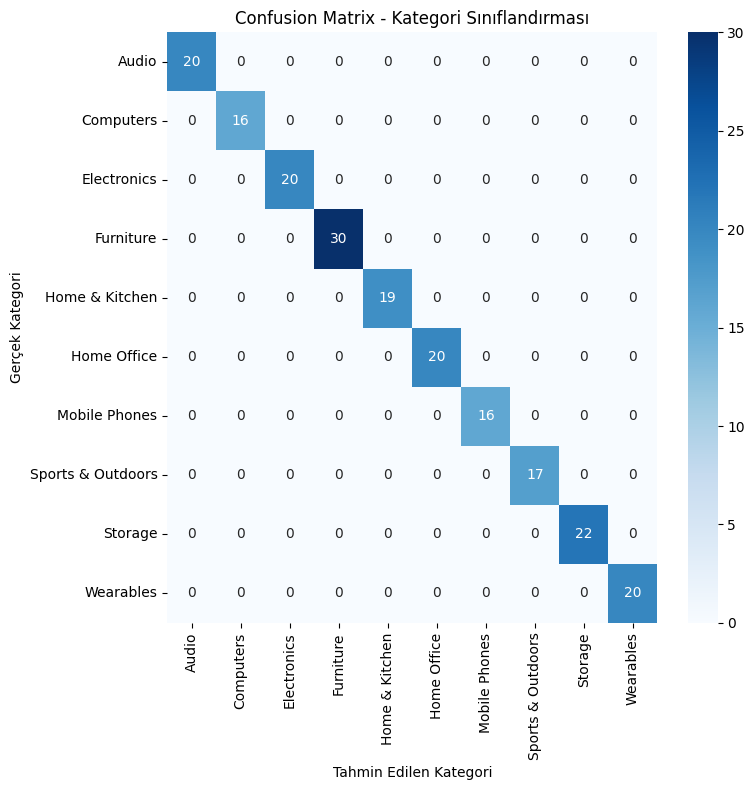

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred, labels=model.classes_)

plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=model.classes_, yticklabels=model.classes_)
plt.xlabel("Tahmin Edilen Kategori")
plt.ylabel("Gerçek Kategori")
plt.title("Confusion Matrix - Kategori Sınıflandırması")
plt.tight_layout()
plt.show()

Bu adımda, test verisi üzerindeki kategori tahminlerinin doğruluğu ölçülmüştür.
Model %100 doğruluk göstermiştir çünkü kullanılan veri seti dengeli, temiz ve açıklamalar nettir.
Ayrıca sınıflandırma raporu ve karışıklık matrisi ile her kategoriye ait performans ayrı ayrı analiz edilmiştir.


In [ ]:
from transformers import T5Tokenizer, T5ForConditionalGeneration
import torch
from tqdm import tqdm

model = T5ForConditionalGeneration.from_pretrained("t5-small")
tokenizer = T5Tokenizer.from_pretrained("t5-small")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

def generate_summary(text):
    input_text = "summarize: " + text
    input_ids = tokenizer.encode(input_text, return_tensors="pt", max_length=512, truncation=True).to(device)
    output_ids = model.generate(input_ids, max_new_tokens=50, num_beams=4, early_stopping=True)
    summary = tokenizer.decode(output_ids[0], skip_special_tokens=True)
    return summary

df['summary'] = df['product_description'].head(100).apply(generate_summary)

### ✏️ 8. Açıklamaların Özetlenmesi (T5 modeli)

Ürün açıklamaları T5 modeliyle özetlenmiştir.(İlk 100 ürün) Bu adım, özellikle uzun ve detaylı açıklamaların sadeleştirilmesini sağlayarak kullanıcıya daha net bilgi sunmayı hedefler.


In [ ]:
from transformers import T5Tokenizer, T5ForConditionalGeneration
import torch
from tqdm import tqdm

model = T5ForConditionalGeneration.from_pretrained("t5-small")
tokenizer = T5Tokenizer.from_pretrained("t5-small")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

def generate_summary(text):
    input_text = "summarize: " + text
    input_ids = tokenizer.encode(input_text, return_tensors="pt", max_length=512, truncation=True).to(device)
    output_ids = model.generate(input_ids, max_new_tokens=50, num_beams=4, early_stopping=True)
    summary = tokenizer.decode(output_ids[0], skip_special_tokens=True)
    return summary

df['summary'] = df['product_description'].head(100).apply(generate_summary)

In [ ]:
import pandas as pd
pd.set_option('display.max_colwidth', None)
df[['product_title', 'product_description', 'summary']].head(10)

,product_title,product_description,summary
0,Wireless Bluetooth Earbuds,High-quality wireless earbuds with Bluetooth 5.0 and long battery life.,high-quality wireless earbuds with Bluetooth 5.0 and long battery life.
1,Stainless Steel Water Bottle,Insulated water bottle keeps drinks cold for 24 hours and hot for 12 hours.,Insulated water bottle keeps drinks cold for 24 hours and hot for 12 hours.
2,Yoga Mat with Carrying Strap,Durable yoga mat with non-slip surface and convenient carrying strap.,Durable yoga mat with non-slip surface and convenient carrying strap.
3,Apple iPhone 13,Latest model of Apple iPhone with A15 Bionic chip and improved battery.,latest model of apple iphone with A15 Bionic chip and improved battery.
4,LED Desk Lamp,LED desk lamp with adjustable brightness and USB charging port.,LED desk lamp with adjustable brightness and USB charging port.
5,Gaming Mouse,Precision gaming mouse with customizable DPI and RGB lighting.,Precision gaming mouse with customizable DPI and RGB lighting.
6,Noise Cancelling Headphones,Over-ear headphones with active noise cancellation and clear sound.,over-ear headphones with active noise cancellation and clear sound.
7,Portable SSD 1TB,1TB solid state drive for fast data transfer and secure storage.,1TB solid state drive for fast data transfer and secure storage.
8,Smartwatch with Heart Rate Monitor,"Smartwatch featuring fitness tracking, heart rate monitor, and notifications.","smartwatch features fitness tracking, heart rate monitor, and notifications."
9,Ergonomic Office Chair,Comfortable office chair with lumbar support and adjustable height.,comfortable office chair with lumbar support and adjustable height.


## 📶 Gerçek ve Tahmin Edilen Kategori Karşılaştırması

Kategori sınıflandırma modelinin performansını daha ayrıntılı analiz edebilmek için, gerçek ve tahmin edilen kategori dağılımları yığılmış bar grafiği ile görselleştirilmiştir.
Bu grafik, modelin hangi kategorilerde daha başarılı olduğunu ve karışıklık yaşadığı sınıfları ortaya koyar.


<Figure size 1200x600 with 0 Axes>

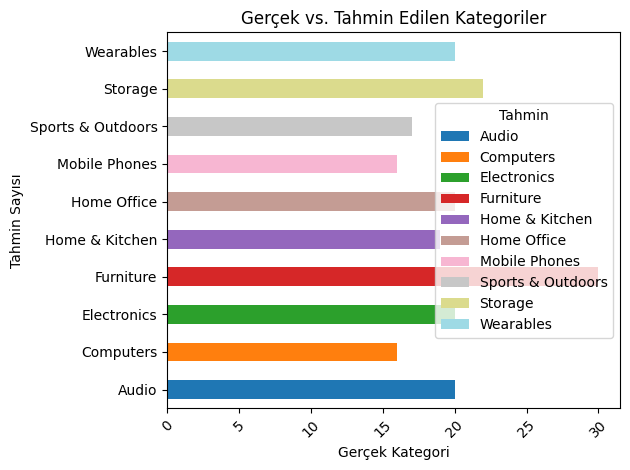

In [ ]:
results_df = pd.DataFrame({'Gerçek': y_test, 'Tahmin': y_pred})

comparison = results_df.groupby(['Gerçek', 'Tahmin']).size().unstack().fillna(0)

plt.figure(figsize=(12, 6))
comparison.plot(kind='barh', stacked=True, colormap='tab20')
plt.title("Gerçek vs. Tahmin Edilen Kategoriler")
plt.xlabel("Gerçek Kategori")
plt.ylabel("Tahmin Sayısı")
plt.legend(title="Tahmin")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Bu grafik, her bir gerçek kategoriye karşılık modelin yaptığı tahminlerin dağılımını göstermektedir.
Her renk, modelin tahmin ettiği farklı bir kategoriyi temsil eder.
Grafik, modelin tüm kategoriler için oldukça dengeli tahminler yaptığını ve karışıklığın minimal olduğunu görsel olarak sunar.

## 🗂️ 7. Kümeleme (KMeans ile Segmentasyon)

Bu aşamada, ürün açıklamalarından elde edilen metin temsilleri TF-IDF yöntemiyle vektörleştirilmiş ve ardından KMeans algoritması kullanılarak 7 kümeye ayrılmıştır.  
Amaç, benzer içerikli ürünlerin gruplandırılarak kategori dışı benzerliklerinin analiz edilmesini sağlamaktır.  
Segmentasyon sonucunda her ürüne bir `küme` numarası atanmıştır.


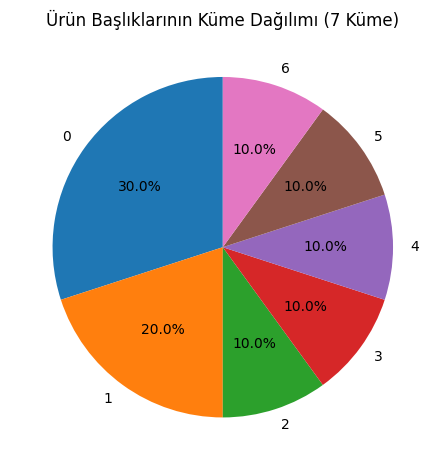

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

vectorizer = TfidfVectorizer(max_features=500, ngram_range=(1, 2))
X_tfidf = vectorizer.fit_transform(df['product_title'])

kmeans = KMeans(n_clusters=7, random_state=42, n_init=10)
df['kume'] = kmeans.fit_predict(X_tfidf)
df['kume'].value_counts().sort_index().plot.pie(
    autopct='%1.1f%%',
    startangle=90,
)

plt.title("Ürün Başlıklarının Küme Dağılımı (7 Küme)")
plt.ylabel("")
plt.tight_layout()
plt.show()

## ⚡ Sentence-Transformers ile Gelişmiş Embedding ve Alternatif Kümeleme

Bu adımda, ürün başlıkları klasik TF-IDF yerine `sentence-transformers` kütüphanesi kullanılarak **anlamsal olarak** vektörleştirilmiştir.  
Bu sayede benzer anlam taşıyan ifadeler birbirine yakın vektörlere dönüşür. Bu yöntem özellikle metin tabanlı kümeleme işlemlerinde daha başarılı sonuçlar verebilir.

👉 Kullanılan model: `all-MiniLM-L6-v2`

Vektörleştirilen başlıklar, ardından **KMeans algoritması** ile 7 kümeye ayrılmıştır. Dağılım pasta grafiği ile görselleştirilmiştir.


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

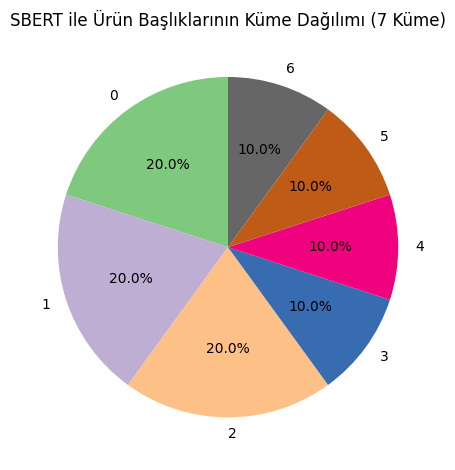

In [ ]:
!pip install -U sentence-transformers --quiet

from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

sbert_model = SentenceTransformer('all-MiniLM-L6-v2')

title_embeddings = sbert_model.encode(df['product_title'], show_progress_bar=True)

kmeans = KMeans(n_clusters=7, random_state=42, n_init=10)
df['sbert_kume'] = kmeans.fit_predict(title_embeddings)

df['sbert_kume'].value_counts().sort_index().plot.pie(
    autopct='%1.1f%%', startangle=90, cmap='Accent'
)
plt.title("SBERT ile Ürün Başlıklarının Küme Dağılımı (7 Küme)")
plt.ylabel("")
plt.tight_layout()
plt.show()